In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import stats
import pingouin as pg
from tqdm.auto import tqdm

### Загрузка данных

In [2]:
path_reg_data = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/q2Yr78SOJICF5g.csv'
path_auth_data = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Tf_wX8_iZA1D2g.csv'

In [3]:
df_reg_data = pd.read_csv(path_reg_data, sep=';')
df_auth_data = pd.read_csv(path_auth_data, sep=';')

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


### Подготовка данных

Посмотрю на первые 5 строк каждой таблицы

In [4]:
df_reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [5]:
df_auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


Посмотрю количество пропущенных значений.

In [6]:
df_reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [7]:
df_auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

Пропусков нет, отлично!
Смотрю типы данных каждой таблицы

In [8]:
df_reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [9]:
df_auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

Судя из описания, первый столбец - даты. Они в формате int64. Переведу в datetime64.

In [10]:
df_reg_data['reg_ts'] = pd.to_datetime(df_reg_data['reg_ts'], unit='s')
df_auth_data['auth_ts'] = pd.to_datetime(df_auth_data['auth_ts'], unit='s')

In [11]:
df_reg_data.head()

,reg_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,2000-01-13 22:27:27,3
3,2000-05-28 14:19:01,4
4,2000-09-16 11:21:53,5


In [12]:
df_auth_data.head()

,auth_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,1999-07-25 16:46:46,2
3,1999-07-31 03:50:15,2
4,1999-08-05 17:49:39,2


Так, по идее, все uid в таблице с регистрациями должны быть уникальными. Это же регистрации. А вот во второй таблице может быть несколько авторизаций в разное время. На всякий случай проверю первую таблицу с регистрациями на уникальность.

In [13]:
df_reg_data.uid.nunique()

1000000

In [14]:
df_reg_data.tail()

,reg_ts,uid
999995,2020-09-23 15:13:54,1110618
999996,2020-09-23 15:14:46,1110619
999997,2020-09-23 15:15:39,1110620
999998,2020-09-23 15:16:31,1110621
999999,2020-09-23 15:17:24,1110622


Отлично! Все уникальные

### Задание 1. Написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

Сначала посмотрим какие даты у первой и последней регистрации.

In [15]:
df_reg_data.reg_ts.min()

Timestamp('1998-11-18 09:43:43')

In [16]:
df_reg_data.reg_ts.max()

Timestamp('2020-09-23 15:17:24')

Данные за 20 лет. Мощно! Чтобы построить когорты от регистрации, нужно соеденить таблицу с авторизациями и таблицу с датой регистрации.

In [17]:
total_df = df_auth_data.merge(df_reg_data, how='left', on='uid')

In [18]:
total_df

,auth_ts,uid,reg_ts
0,1998-11-18 09:43:43,1,1998-11-18 09:43:43
1,1999-07-22 22:38:09,2,1999-07-22 22:38:09
2,1999-07-25 16:46:46,2,1999-07-22 22:38:09
3,1999-07-31 03:50:15,2,1999-07-22 22:38:09
4,1999-08-05 17:49:39,2,1999-07-22 22:38:09
...,...,...,...
9601008,2020-09-23 15:13:54,1110618,2020-09-23 15:13:54
9601009,2020-09-23 15:14:46,1110619,2020-09-23 15:14:46
9601010,2020-09-23 15:15:39,1110620,2020-09-23 15:15:39
9601011,2020-09-23 15:16:31,1110621,2020-09-23 15:16:31


Так, по скольку я джоинил таблицу через Left могли появиться пустые строки. Проверю.

In [19]:
total_df.isna().sum()

auth_ts    0
uid        0
reg_ts     0
dtype: int64

Всё ок! Теперь можно написать функцию, которая будет выводить Retention. По скольку данных очень много, то лучше сделать функцию с параметрами. В функцию нужно будет передать датафрейм, дату первой регистрации и длину когорты.

In [20]:
def retention_rate(df, start_date, delay):
    
    start_date = pd.Timestamp(start_date)
    end_date = start_date + pd.Timedelta(days = delay)
    
    df = df.query('reg_ts >= @start_date & auth_ts <= @end_date')
    
    ''' Вычисляю разницу в днях между авторизацией и регистрацией. Так же прибалю единицу, 
        чтобы учесть сам день авторизации.
        Например, если пользователь зарегистрировался 1 декабря и авторизовался 2 декабря, 
        то разница в днях между датами будет 1, но прибавление 1 дня даст значение 2, 
        что более точно отражает факт, что пользователь использовал приложение 
        на следующий день после регистрации. '''

    df['day_diff'] = (df['auth_ts'] - df['reg_ts']).dt.days + 1
    
    # делаю столбец с датой когорт по дате регистрации
    df['kogorta'] = df.reg_ts.apply(lambda x: x.strftime('%Y-%m-%d'))
    
    # группирую таблицу и считаю уникальных пользователей в этот день
    df = df.groupby(['kogorta', 'day_diff'], as_index=False).agg({'uid': 'nunique'})
    
    # переворачиваю таблицу
    df_pivot = df.pivot(index = 'kogorta', columns = 'day_diff', values = 'uid')
    
    # беру весь первый столбец и делю каждый столбец на него.
    cohort_size = df_pivot.iloc[:,0]
    retention = df_pivot.divide(cohort_size, axis = 0)

    # Строю красивую табличку
    plt.figure(figsize = (25, 25))

    plt.title('Retention', fontsize = 18)

    sns.heatmap(retention, annot = True, fmt = '.1%',cmap = 'PuBu', vmin = 0.0 , vmax = 0.1)
    plt.ylabel('Kogorta')
    plt.xlabel('Day')
    plt.show()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


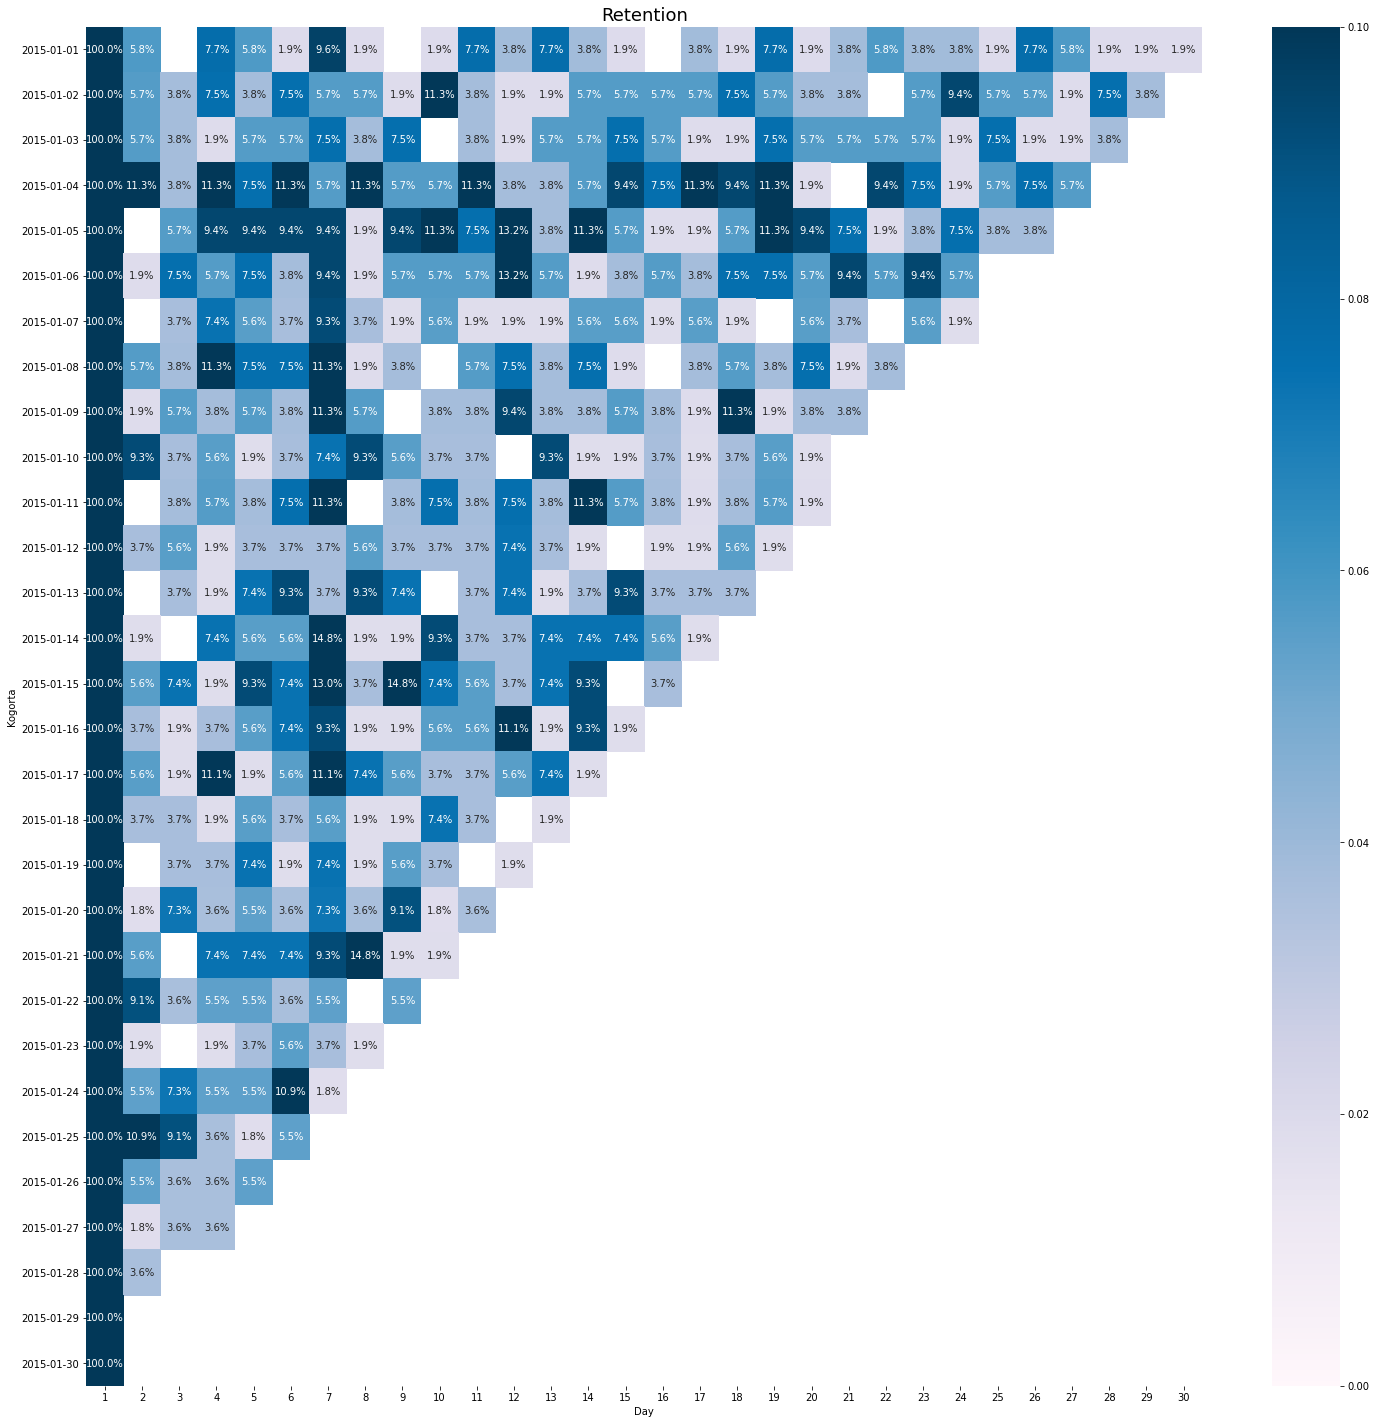

In [21]:
retention_rate(total_df, '2015-01-01', 30)

Отлично! Из таблицы за 2015 год видно, что 9.6% пользователей, зарегистрировавшихся 1 января вернулись на 7й день.

### Задание 2. Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667. Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

##### Загрузка данных и подготовка данных

In [22]:
df_step2 = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/SOkIsD5A8xlI7Q', sep=';')

In [23]:
df_step2.tail()

,user_id,revenue,testgroup
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a
404769,404770,0,b


In [24]:
df_step2.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [25]:
df_step2.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

С типами данных всё ок, пропусков нет. 

##### Сверка показателей

Сравню количество пользователей в двух группах.

In [26]:
df_step2.groupby('testgroup', as_index=False).agg({'user_id': ['count', 'nunique']})

testgroup user_id        
              count nunique
0         a  202103  202103
1         b  202667  202667

Количество уников примерно одинаковое, перекосов нет - это хорошо. Ещё видно, что в таблице только уникальные значения.

Сверю количество платящих пользователей в обеих группах

In [27]:
df_step2.query('revenue > 0').groupby('testgroup', as_index=False).agg({'user_id': 'count'})

,testgroup,user_id
0,a,1928
1,b,1805


C заданием сходится - отлично. Сверю ещё APRU.

И сверю ARPU с заданием на всякий случай

In [28]:
df_step2.groupby('testgroup', as_index=False) \
        .agg({'revenue':'sum', 'user_id':'count'}) \
        .assign(arpu=lambda x: x['revenue'] / x['user_id'],
                arpu_delta=lambda x: (x['arpu'].iloc[1] - x['arpu'].iloc[0]) / x['arpu'].iloc[1] * 100)

,testgroup,revenue,user_id,arpu,arpu_delta
0,a,5136189,202103,25.413720,5.000009
1,b,5421603,202667,26.751287,5.000009


Действительно, во второй группе ARPU выше на 5%.

Посчитаю ARPPU и CR, это дополнительные показатели, которые помогут взглянуть на данные с другого угла.

ARPPU = Revenue / Paying Users

In [29]:
df_step2.query('revenue > 0').groupby('testgroup', as_index=False) \
        .agg({'revenue':'sum', 'user_id':'count'}) \
        .assign(arppu=lambda x: x['revenue'] / x['user_id'],
                arppu_delta=lambda x: (x['arppu'].iloc[1] - x['arppu'].iloc[0]) / x['arppu'].iloc[1] * 100)

,testgroup,revenue,user_id,arppu,arppu_delta
0,a,5136189,1928,2663.998444,11.308202
1,b,5421603,1805,3003.658172,11.308202


ARPPU тестовой группы выше на 11,3%

Посчитаю CR. (Paid users / all users)

Сделаю сразу 2 выборки. Со всеми пользователями, и с платящими. Так будет проще

In [30]:
group_a_all = df_step2.query('testgroup == "a"')

In [31]:
group_b_all = df_step2.query('testgroup == "b"')

In [32]:
group_a_revenue = df_step2.query('testgroup == "a" & revenue > 0')

In [33]:
group_b_revenue = df_step2.query('testgroup == "b" & revenue > 0')

In [34]:
cr_a_group = round(group_a_revenue.revenue.count() / group_a_all.revenue.count() * 100, 2)

In [35]:
cr_b_group = round(group_b_revenue.revenue.count() / group_b_all.revenue.count() * 100, 2)

In [36]:
round(cr_b_group - cr_a_group, 2)

-0.06

### Итого имеем:
##### - ARPU у тестовой группы выше на 5%
##### - ARPPU у тестовой группы выше на 11
##### - %Конверсии в контрольной группе выше примерно на 6%

Посмотрю распределение выручки в двух группах. Возможно есть какие-то выбросы, которые сильно влияют на статисику

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


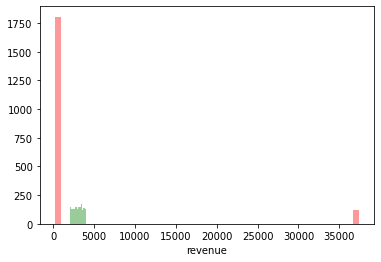

In [37]:
sns.distplot(group_a_revenue.revenue, kde=False, color="r")
sns.distplot(group_b_revenue.revenue, kde=False, color="g")

По графику видно, что в тестовой группе данные распределены в одном диапазоне, в контрольной - в двух. У большинства revenue ниже, но есть какая-то доля пользователей, которые много платят. И, судя по высоте столбика (где-то половина от 250) - это явно не один пользователь. Вообще можно посчитать для понимания масштаба.

In [38]:
group_a_revenue.query('revenue > 35000').user_id.count()

123

In [39]:
round(group_a_revenue.query('revenue > 35000').user_id.count() / group_a_revenue.user_id.count() * 100, 2)

6.38

In [40]:
round(group_a_revenue.query('revenue > 35000').revenue.sum() / group_a_revenue.revenue.sum() * 100, 2)

89.37

У нас есть 133 пользователя, которые хорошо платят и составляют 6% от общего числа платящих в контрольной группе. При этом они зарабатывают 89% от всего дохода. Я бы не назвал это каким-то единичным выбросом, который нужно убирать. Если бы там была пара пользователей - убрал бы из выборки вообще не задумываясь.

#### Теперь переходим к работе с результатами теста

Сначала нужно определить нормальность распределения каждой выборки (от этого будет зависеть какой метод анализа я выберу дальше, параметрический или нет). Методов проверки на нормальность несколько, я более-менее знаю про метод Шапиро-Уилка, метод Q-Q. Метод Шапиро-Уилка крайне чувствителен к выбросам. Сам Jupyter вообще предлагает сделать сэмплирование и ограничить выборку до 5000. Если я ограничу, в выборку группы А могут попасть супер-высокие чеки (судя по распределению, которое я построил чуть выше). Но для уверенности я проведу оба теста.

- H0: распределение не отличается от нормального (pvalue > 0.05)
- H1: распределение отличается от нормального (pvalue < 0.05)

In [41]:
stats.shapiro((group_a_all.revenue).sample(5000))

ShapiroResult(statistic=0.0043697357177734375, pvalue=0.0)

In [42]:
stats.shapiro((group_b_all.revenue).sample(5000))

ShapiroResult(statistic=0.07204407453536987, pvalue=0.0)

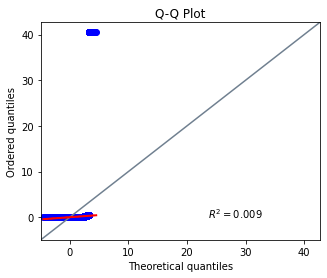

In [43]:
pg.qqplot(group_a_all.revenue) 

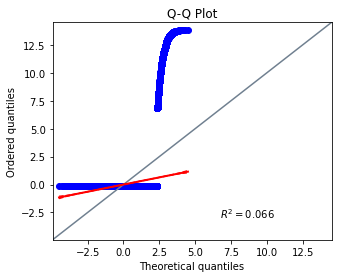

In [44]:
pg.qqplot(group_b_all.revenue) 

Отклоняем нулевую гипотезу. Распраделение ненормальное. QQ-Plot это подтверждает. Если бы было нормальное - данные точки выстроились бы в диагональную линию.

Сделаю тест на нормальность для контрольной группы, но исключу высокие чеки.

In [45]:
stats.shapiro((group_a_all.query('revenue < 35000').revenue.sample(5000)))

ShapiroResult(statistic=0.05974799394607544, pvalue=0.0)

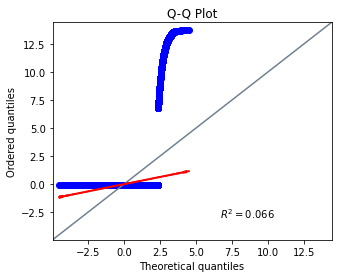

In [46]:
pg.qqplot(group_a_all.query('revenue < 35000').revenue) 

В целом, всё так-же ненормально.

#### Проверка на статзначимость.

Для проверки статзначимости различий воспользуюсь бутстрапом. Бутстрап подходит для любых распределений.

Проверки будут проходить следующим образом: если pvalue > 0.05 и 0 попадает в доверительный интервал - статзначимых различий нет.

In [48]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin = 0,ymax = 50,linestyle = '--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"p_value": p_value}

Тест 1 - Полностью сравним группы.

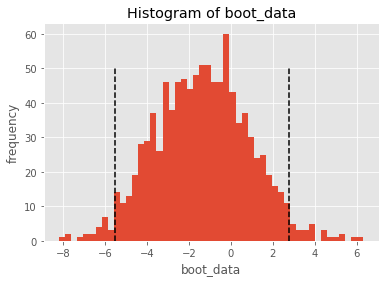

Результат bootstrap-теста:
p-value: 0.54


In [62]:
booted_data = get_bootstrap(group_a_all.revenue, group_b_all.revenue)
print('Результат bootstrap-теста:')
print(f'p-value: {booted_data ["p_value"]:.2f}')

Первый тест подтверждает что различий нет. Сейчас мы сравнили ARPU

Тест 2 - сравним данные только по платящим пользователям, ARPPU.

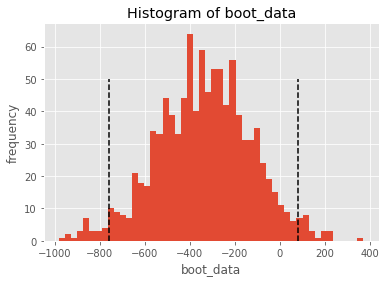

Результат bootstrap-теста:
p-value: 0.11


In [50]:
booted_data = get_bootstrap(group_a_revenue.revenue, group_b_revenue.revenue)
print('Результат bootstrap-теста:')
print(f'p-value: {booted_data ["p_value"]:.2f}')

Результат - различий нет.

Тест 3 - сравним данные только по платящим пользователям + дополнительно убираем высокие чеки из первой. Сравним ARPPU с корректировками.

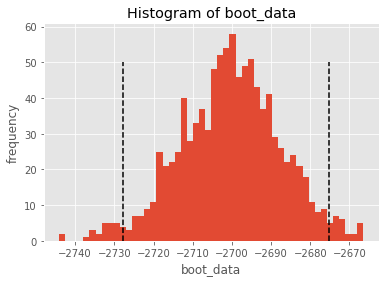

Результат bootstrap-теста:
p-value: 0.00


In [51]:
booted_data = get_bootstrap(group_a_revenue.query('revenue < 35000').revenue, group_b_revenue.revenue)
print('Результат bootstrap-теста:')
print(f'p-value: {booted_data ["p_value"]:.2f}')

Вот это интересно, здесь есть статзначимые различия, но только потому, что я убрал часть хорошо платящих пользователей из контрольной группы. В таком случае, сделаем тест ARPPU, но только с медианой. Потому что среднее значение сильно смещается из-за больших чеков первой группы.

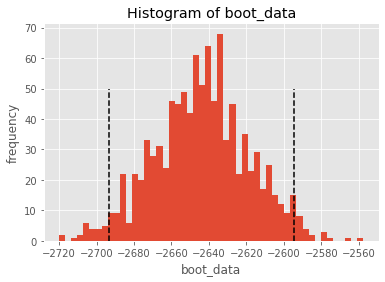

Результат bootstrap-теста:
p-value: 0.00


In [52]:
booted_data = get_bootstrap(group_a_revenue.revenue, group_b_revenue.revenue, statistic = np.median)
print('Результат bootstrap-теста:')
print(f'p-value: {booted_data ["p_value"]:.2f}')

Вот оно! Теперь можно сделать следующий вывод. Вспомним изначальные данные.

In [53]:
df_step2.groupby('testgroup', as_index=False) \
        .agg({'revenue':'sum', 'user_id':'count'}) \
        .assign(arpu=lambda x: x['revenue'] / x['user_id'],
                arpu_delta=lambda x: (x['arpu'].iloc[1] - x['arpu'].iloc[0]) / x['arpu'].iloc[1] * 100)

,testgroup,revenue,user_id,arpu,arpu_delta
0,a,5136189,202103,25.413720,5.000009
1,b,5421603,202667,26.751287,5.000009


In [54]:
df_step2.query('revenue > 0').groupby('testgroup', as_index=False) \
        .agg({'revenue':'sum', 'user_id':'count'}) \
        .assign(arppu=lambda x: x['revenue'] / x['user_id'],
                arppu_delta=lambda x: (x['arppu'].iloc[1] - x['arppu'].iloc[0]) / x['arppu'].iloc[1] * 100)

,testgroup,revenue,user_id,arppu,arppu_delta
0,a,5136189,1928,2663.998444,11.308202
1,b,5421603,1805,3003.658172,11.308202


In [55]:
print('Разница конверсий между тестовой и контрольной группой: ', round(cr_b_group - cr_a_group, 2), '%', sep='')

Разница конверсий между тестовой и контрольной группой: -0.06%


In [56]:
group_a_revenue.revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [57]:
group_b_revenue.revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

- ARPU у тестовой группы выше на 5%
- ARPPU у тестовой группы выше на 11
- %Конверсии в контрольной группе выше примерно на 6%

#### Исходя из тестов. У ARPU и ARPPU нет значимых различий. В общем, малая часть пользователей контрольной группы (которая делает 80+% от дохода) компенсирует маленькие покупки контрольной группе. И если сравнивать 2 тестовую и контрольную группу, различий, в среднем, нет.

#### Но если взять медианное значение ARPPU, то тут уже гораздо интересней и различия есть. И отличия ну прямо знначимы, почти в 10 раз. Другими словами, медианные чеки пользователей больше в 10 раз. Ну это и логично, если вспомнить распределение по revenue, которое я строил выше.

#### По результатам теста я бы остановился на тестовой группе. Вариант без "сильно платящей" группы куда более приятен, стабилен, предсказуем. Но это всё со статистической точки зрения. Я выбираю тестовую группу. Но чтобы принять окончательное решение, нужно брать во внимание дополнительные параметры. Например на сколько акция или подобное мероприятие влияет на маржинальность и подобные продуктовые показатели. Вобщем всё, что мы проходили в блоке продуктовой аналитики.

Теперь осталось только разобраться с конверсией. Возьмём исходный датафрейм и сделаем ещё один столбец. CR. Если пользователь совершил конверсию - ставим туда единицу, если нет - 0

In [58]:
df_ct_test = df_step2

In [59]:
df_ct_test['cr'] = df_ct_test['revenue'].apply(lambda x: 0 if x == 0 else 1)

In [60]:
df_ct_test.tail()

,user_id,revenue,testgroup,cr
404765,404766,0,a,0
404766,404767,0,b,0
404767,404768,231,a,1
404768,404769,0,a,0
404769,404770,0,b,0


Сравним CR всё тем же бутстрапом

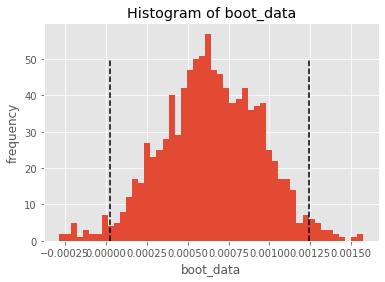

Результат bootstrap-теста:
p-value: 0.03


In [61]:
booted_data = get_bootstrap(df_ct_test.query('testgroup == "a"').cr, df_ct_test.query('testgroup == "b"').cr)
print('Результат bootstrap-теста:')
print(f'p-value: {booted_data ["p_value"]:.2f}')

Доверительный интервал не пересекает 0, pvalue < 0.05. Различия статзначимы.

#### Да, выходит, что CR во второй группе статзначимо хуже. Но если брать всё в сумме, то тестовая группа B по прежнему остаётся лидером. Как и писал выше, я считаю, что лучше работать с чем-то предсказуемым и стабильным.

### Задание 3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

<br>- **ARPU/ARPPU** (Average revenue per user) - средний чек на пользователя / платящего пользователя. Возможно пользователям будет тяжело проходить уровни и они решат приобрести внутриигровую валюту или другие бонусы, чтобы всё таки пройти уровни.

<br>- **Conversion Rate(CR)** - отношение количетва пользователей, присоединившихся к тематическому событию, к количеству пользователей заходивших в игру в данный период.

<br>- **Retention rate** для пользователей, присоединившихся к событию

<br>- **DAU/WAU/MAU** - количество активных пользователей за день/неделю/месяц.

<br>- **Stickiness** - "Липкость продукта" (Stickiness = (DAU / MAU) * 30).


##### Если усложнять механику, я бы добавил следующие показатели:

<br> - **Средняя продолжительность сессии** - покажет мотивацию пользователей в получении награды, сложности прохождения события.

<br>- **Среднее количество сессий на пользователя**

<br>- **Среднее количество попыток до завершения уровня** - поймём на сколько сложно вообще проходить уровни.

<br>- **Количество завершённых уровней**

<br>- **Churn rate** - метрика, которая покажет, как много игроков прекращают играть в игру после неудачной попытки выполнения уровня и отката на несколько уровней назад. Коэффициент оттока можно рассчитать как отношение числа игроков, прекративших играть, к общему числу участников события.

Все эти показатели позволяют оценить на сколько усложнилась игровая механика и какое влияние она производит на пользователей.